## Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from modules.util.util import importstr, run_shell_cmd, get_best_model
from modules.util.logconf import logging
log = logging.getLogger('nb')

## Train

This is a semi-automated process. The learning rate will need to be manually set based on the results of the learning rate finder on the training dataset

First set the folder location of the training data

In [3]:
train_data_path = '/home/fsuser/programming/datasets/COVID-19-20_v2/Train'

Then generate a metadata file and prepare a cache of preprocessed data. This will create a metadata/df_meta.fth file as well as a cache/ folder in the current directory.

In [4]:
run_shell_cmd(log, 'prepcache.CovidPrepCacheApp', f'--data-path={train_data_path}', 
              f'--num-workers={4}', f'--batch-size={20}')

2020-12-10 18:49:02,196 INFO     pid:27213 nb:064:run_shell_cmd Running: prepcache.CovidPrepCacheApp(['--data-path=/home/fsuser/programming/datasets/COVID-19-20_v2/Train', '--num-workers=4', '--batch-size=20']).main()
2020-12-10 18:49:03,344 INFO     pid:27213 numexpr.utils:129:_init_num_threads Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-12-10 18:49:03,346 INFO     pid:27213 numexpr.utils:141:_init_num_threads NumExpr defaulting to 8 threads.
2020-12-10 18:49:03,364 INFO     pid:27213 prepcache:073:__init__ Creating metadata folder


,uid,ct_fname,mask_fname
0,534,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...
1,255,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...
2,361,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...
3,228,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...
4,214,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...
...,...,...,...
194,039,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...
195,504,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...
196,263,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...
197,623,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...


2020-12-10 18:49:03,377 INFO     pid:27213 prepcache:078:__init__ Creating data_path environment variable in new .env file
2020-12-10 18:49:03,379 INFO     pid:27213 prepcache:081:main Starting CovidPrepCacheApp, Namespace(batch_size=20, data_path='/home/fsuser/programming/datasets/COVID-19-20_v2/Train', num_workers=4, width_irc=[16, 128, 128])
100%|██████████| 10/10 [02:15<00:00, 13.60s/it]
2020-12-10 18:51:19,491 INFO     pid:27213 nb:069:run_shell_cmd Finished: prepcache.CovidPrepCacheApp.['--data-path=/home/fsuser/programming/datasets/COVID-19-20_v2/Train', '--num-workers=4', '--batch-size=20'].main()


Use lr finder to find a good learning rate. This will run the model through a hundered batches which take a few minutes to complete on the gpu.

2020-12-10 18:51:30,204 INFO     pid:27213 nb:064:run_shell_cmd Running: modules.util.lr_finder.LearningRateFinder([]).main()
2020-12-10 18:51:33,622 INFO     pid:27213 modules.dsets:263:__init__ TrainingCovid2dSegmentationDataset: training mode, 159 uid's, 159 steps_per_epoch
2020-12-10 18:51:33,627 INFO     pid:27213 modules.dsets:288:__init__ TrainingCovid2dSegmentationDataset: (16, 128, 128) width_irc



Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 3.13E-02


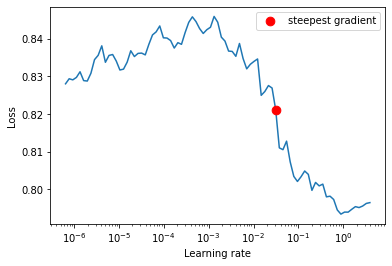

(<matplotlib.axes._subplots.AxesSubplot at 0x7f2448b89d60>,
 0.031257158496882355)

2020-12-10 18:53:29,467 INFO     pid:27213 nb:069:run_shell_cmd Finished: modules.util.lr_finder.LearningRateFinder.[].main()


In [5]:
run_shell_cmd(log, 'modules.util.lr_finder.LearningRateFinder')

Set the value of learning rate as found by the learning rate finder

In [6]:
learning_rate = 3e-2

Begin training. Validation will run every 5 epochs and a copy of the model parameters will be saved under saved-models/ folder. The best model based on F1 score is saved with the prefix `.best.state`

In [7]:
run_shell_cmd(log, 'training.CovidSegmentationTrainingApp', f'--lr={learning_rate}')

2020-12-10 18:54:47,079 INFO     pid:27213 nb:064:run_shell_cmd Running: training.CovidSegmentationTrainingApp(['--lr=0.03']).main()
2020-12-10 18:54:47,261 INFO     pid:27213 training:201:init_model Using CUDA; 2 devices.
2020-12-10 18:54:47,288 INFO     pid:27213 modules.dsets:263:__init__ TrainingCovid2dSegmentationDataset: training mode, 179 uid's, 320 steps_per_epoch
2020-12-10 18:54:47,290 INFO     pid:27213 modules.dsets:288:__init__ TrainingCovid2dSegmentationDataset: (16, 128, 128) width_irc
2020-12-10 18:54:47,291 INFO     pid:27213 modules.dsets:263:__init__ Covid2dSegmentationDataset: validation mode, 20 uid's, 20 steps_per_epoch
2020-12-10 18:54:47,294 INFO     pid:27213 training:465:main Starting CovidSegmentationTrainingApp, Namespace(augment_flip=False, augment_noise=False, augment_offset=False, augment_rotate=False, augment_scale=False, augmented=True, batch_size=2, ct_window='shifted_lung', depth=3, epochs=600, freeze=False, lr=0.03, model_path=None, num_workers=4, st

epoch,loss/trn,dice_loss/trn,ce_loss/trn,loss/val,dice_loss/val,ce_loss/val,metrics_val/miss_rate,metrics_val/fp_to_mask_ratio,pr_val/precision,pr_val/recall,pr_val/f1_score,surface_dist_val/mean,surface_dist_val/root_mean_squared,surface_dist_val/hausdorff
1,0.8169,0.8971,0.6298,0.8795,0.9928,0.6150,0.6380,84.6034,0.0043,0.3620,0.0084,146.0246,155.3914,305.6368


2020-12-10 18:57:18,650 INFO     pid:27213 training:364:log_metrics E1 CovidSegmentationTrainingApp
2020-12-10 18:57:18,656 INFO     pid:27213 training:400:log_metrics E1 trn      0.8169 loss, 0.8971 dice loss, 0.6298 ce loss, 0.0648 precision, 0.5927 recall, 0.1169 f1 score 0.4073 miss rate 8.5503 fp to label ratio
2020-12-10 19:02:55,627 INFO     pid:27213 training:364:log_metrics E1 CovidSegmentationTrainingApp
2020-12-10 19:02:55,632 INFO     pid:27213 training:411:log_metrics E1 val      0.8795 loss, 0.9928 dice loss, 0.6150 ce_loss, 0.0043 precision, 0.3620 recall, 0.0084 f1 score 0.6380 miss rate 84.6034 fp to label ratio146.0246 mean distance155.3914 root mean squared distance305.6368 hausdorff distance
2020-12-10 19:02:55,679 INFO     pid:27213 training:451:save_model Saved model params to saved-models/2020-12-10_18.54.47.320.state
2020-12-10 19:02:55,688 INFO     pid:27213 training:456:save_model Saved model params to saved-models/2020-12-10_18.54.47.best.state
2020-12-10 19:

KeyboardInterrupt: 

## Inference

In [3]:
inference_data_path = '/home/fsuser/programming/datasets/COVID-19-20_TestSet/'

Once again, we prepare the metadata and cache files. Note that this will overwrite the metadatafile from the train set

In [4]:
run_shell_cmd(log, 'prepcache.CovidPrepCacheApp', f'--data-path={inference_data_path}', f'--num-workers={4}', f'--batch-size={20}')

2020-12-10 19:52:01,356 INFO     pid:28312 nb:064:run_shell_cmd Running: prepcache.CovidPrepCacheApp(['--data-path=/home/fsuser/programming/datasets/COVID-19-20_TestSet/', '--num-workers=4', '--batch-size=20']).main()
2020-12-10 19:52:02,437 INFO     pid:28312 numexpr.utils:129:_init_num_threads Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2020-12-10 19:52:02,443 INFO     pid:28312 numexpr.utils:141:_init_num_threads NumExpr defaulting to 8 threads.
2020-12-10 19:52:02,460 INFO     pid:28312 prepcache:075:__init__ Creating metadata folder


,uid,ct_fname,mask_fname
0,679,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...
1,16434369_01-05-2012-CT CHEST ABDOMEN PELVIS W-...,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...
2,16406513_12-24-2011-CT PE CHEST-83965_5,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...
3,16406508_02-12-2012-CT CHEST ABDOMEN PELVIS W-...,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...
4,373,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...
...,...,...,...
41,16407187_01-28-2012-CT PE CHEST-34292_5,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...
42,16445144_03-13-2012-CT PE CHEST-17430_5,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...
43,16406490_02-05-2012-CT PE CHEST-37142_5,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...
44,16424111_02-08-2012-CT CHEST ABDOMEN PELVIS W-...,/home/fsuser/programming/datasets/COVID-19-20_...,/home/fsuser/programming/datasets/COVID-19-20_...


2020-12-10 19:52:02,475 INFO     pid:28312 prepcache:080:__init__ Creating data_path environment variable in new .env file
2020-12-10 19:52:02,478 INFO     pid:28312 prepcache:083:main Starting CovidPrepCacheApp, Namespace(batch_size=20, data_path='/home/fsuser/programming/datasets/COVID-19-20_TestSet/', num_workers=4, width_irc=[16, 128, 128])
100%|██████████| 3/3 [01:24<00:00, 28.08s/it]
2020-12-10 19:53:26,811 INFO     pid:28312 nb:069:run_shell_cmd Finished: prepcache.CovidPrepCacheApp.['--data-path=/home/fsuser/programming/datasets/COVID-19-20_TestSet/', '--num-workers=4', '--batch-size=20'].main()


You can specify a UID from a CT scan based on the number found in the filename.
For example, pass in `0180_0` for `volume-covid19-A-0180_0_ct.nii.gz`

In [ ]:
run_shell_cmd(log, 'inference.CovidInferenceApp', '0180_0', f'--data-path={inference_data_path}')

If you wish to explicitly specify a model path, just pass in a `--model-flag="model path"` flag

In [ ]:
model_path = get_best_model('saved-models', '2020-12-08_19.15.04.best.state') # params = model_folder, model_file_name
run_shell_cmd(log, 'inference.CovidInferenceApp', '0180_0', f'--data-path={inference_data_path}', f'--model-path={model_path}')

To run inference on all of the files, simply pass the `--run-all` flag as shown below

In [4]:
run_shell_cmd(log, 'inference.CovidInferenceApp', f'--data-path={inference_data_path}', '--run-all')

# again you can specify a model path if you wish
# run_shell_cmd(log, 'inference.CovidInferenceApp', f'--data-path={inference_data_path}', f'--model-path={model_path}', '--run-all')

2020-12-10 19:54:48,938 INFO     pid:28513 nb:064:run_shell_cmd Running: inference.CovidInferenceApp(['--data-path=/home/fsuser/programming/datasets/COVID-19-20_TestSet/', '--run-all']).main()
2020-12-10 19:54:53,557 INFO     pid:28513 inference:150:main Starting CovidInferenceApp, Namespace(batch_size=1, data_path='/home/fsuser/programming/datasets/COVID-19-20_TestSet/', model_path=None, num_workers=4, run_all=True, uid=None, width_irc=[16, 128, 128])
2020-12-10 19:54:53,954 INFO     pid:28513 modules.dsets:263:__init__ Covid2dSegmentationDataset: general mode, 1 uid's, 1 steps_per_epoch
2020-12-10 19:54:53,956 INFO     pid:28513 inference:129:segment_ct Running inference for uid: 679
2020-12-10 19:54:55,055 INFO     pid:28513 inference:131:segment_ct input shape torch.Size([70, 512, 512])
2020-12-10 19:55:01,356 INFO     pid:28513 inference:146:segment_ct output shape: (70, 512, 512)
2020-12-10 19:55:02,482 INFO     pid:28513 modules.dsets:263:__init__ Covid2dSegmentationDataset: gen